# Modeling Household Radon Levels with Bayesian Multilevel Regression

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 6]

In [2]:
from pprint import pprint

import IPython
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import patsy
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import tensorflow_probability as tfp

In [3]:
from tensorflow_probability import edward2 as ed

#### Load and format data

In [4]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/radon.csv')

# select columns from source
df = df[['log_radon', 'floor', 'county', 'Uppm']]

# format columns as desired
df['county'] = df['county'].astype('category').cat.codes

# create train / test split
train = df.sample(frac=0.8, random_state=np.random.RandomState(seed=0))
test = df.drop(train.index)

train.head()

,log_radon,floor,county,Uppm
306,1.568616,0.0,25,0.907991
711,0.788457,0.0,69,0.622088
298,0.693147,0.0,25,0.907991
466,2.341806,0.0,44,1.150760
253,2.292535,1.0,24,1.217270


#### features...
* floor -- np.float32 (we'll be regressing on this)
* county category -- np.int32
* county-level Uranium -- np.float32

In [5]:
labels_train = train['log_radon'].values.astype(np.float32)

features_train = dict()
features_train['floor'] = train['floor'].values.astype(np.float32)
features_train['county'] = train['county'].values.astype(np.int32)
features_train['Uppm'] = train['Uppm'].values.astype(np.float32)


labels_test = test['log_radon'].values.astype(np.float32)

features_test = dict()
features_test['floor'] = test['floor'].values.astype(np.float32)
features_test['county'] = test['county'].values.astype(np.int32)
features_test['Uppm'] = test['Uppm'].values.astype(np.float32)

In [6]:
num_counties = max(features_train['county']) + 1
num_observations = train.shape[0]

print("Number of counties:", num_counties)
print("Number of observations:", num_observations)

Number of counties: 85
Number of observations: 735


#### Define models

In [7]:
def model_pooled(features):
    # define trainable variables
    intercept = tf.get_variable("intercept", [])
    effect_floor = tf.get_variable("effect_floor", [])  # coefficient for num floors
    
    # define prior for output
    mean = intercept + effect_floor * features["floor"]
    log_radon = ed.Normal(loc=mean, scale=1., name="log_radon")
    return log_radon


def model_with_fixed_county_effects(features):
    # define trainable variables
    intercept = tf.get_variable("intercept", [])
    effect_floor = tf.get_variable("effect_floor", [])  # coefficient for num floors
    effect_counties = tf.get_variable("effect_counties", [num_counties])  # county level effects

    # define prior for output
    mean = intercept \
        + effect_floor * features["floor"] \
        + tf.gather(effect_counties, features["county"])  # gather is faster than matmul for indicator matrices
    log_radon = ed.Normal(loc=mean, scale=1., name="log_radon")
    return log_radon


def model_with_random_county_effects(features):
    # fixed effects
    intercept = tf.get_variable("intercept", [])
    effect_floor = tf.get_variable("effect_floor", [])  # coefficient for num floors
    
    # random effects
    # hyperpriors
    stddev_counties = tf.exp(tf.get_variable("stddev_unconstrained_counties", []))
    # priors
    effect_counties = ed.MultivariateNormalDiag(
        loc=tf.zeros(num_counties),
        scale_identity_multiplier=stddev_counties,
        name="effect_counties")
    
    # prior for output
    mean = intercept \
        + effect_floor * features["floor"] \
        + tf.gather(effect_counties, features["county"])  # gather is faster than matmul for indicator matrices
    log_radon = ed.Normal(loc=mean, scale=1., name="log_radon")
    return log_radon


def model_with_random_county_effects_with_uranium(features):
    '''
    Come back to this. Left off at defining prior for the county uraniam effect.
    '''
    # fixed effects
    intercept = tf.get_variable("intercept", [])
    effect_floor = tf.get_variable("effect_floor", [])  # coefficient for num floors
    
    # random effects
    # hyperpriors
    stddev_counties = tf.exp(tf.get_variable("stddev_unconstrained_counties", []))
    # priors
    ## where I left off:
#     mean_effect_county_uranium = tf.get_variable("mean_effect_county_uranium", [])
#     effect_county_uranium = ed.Normal(loc=mean_effect_county_uranium, ????)
    effect_county_uranium = tf.get_variable("effect_county_uranium", [])
    effect_counties_loc = effect_county_uranium * features["county_uranium"]
    effect_counties = ed.MultivariateNormalDiag(
        loc=effect_counties_loc,
        scale_identity_multiplier=stddev_counties,
        name="effect_counties")
    
    # prior for output
    mean = intercept \
        + effect_floor * features["floor"] \
        + tf.gather(effect_counties, features["county"])  # gather is faster than matmul for indicator matrices
    log_radon = ed.Normal(loc=mean, scale=1., name="log_radon")
    return log_radon


In [8]:
model_template = tf.make_template("model_pooled", model_with_random_county_effects)

In [9]:
def strip_consts(graph_def, max_const_size=32):
  """Strip large constant values from graph_def."""
  strip_def = tf.GraphDef()
  for n0 in graph_def.node:
    n = strip_def.node.add()
    n.MergeFrom(n0)
    if n.op == 'Const':
      tensor = n.attr['value'].tensor
      size = len(tensor.tensor_content)
      if size > max_const_size:
        tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
  return strip_def

def draw_graph(model, *args, **kwargs):
  """Visualize TensorFlow graph."""
  graph = tf.Graph()
  with graph.as_default():
    model(*args, **kwargs)
  graph_def = graph.as_graph_def()
  strip_def = strip_consts(graph_def, max_const_size=32)
  code = """
      <script>
        function load() {{
          document.getElementById("{id}").pbtxt = {data};
        }}
      </script>
      <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
      <div style="height:600px">
        <tf-graph-basic id="{id}"></tf-graph-basic>
      </div>
  """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

  iframe = """
      <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
  """.format(code.replace('"', '&quot;'))
  IPython.display.display(IPython.display.HTML(iframe))


draw_graph(model_with_random_county_effects, features_train)

### Fit models

In [10]:
log_joint = ed.make_log_joint_fn(model_template)

def target_log_prob_fn(effect_counties):
  """Unnormalized target density as a function of states."""
  return log_joint(  # fix `features` and `ratings` to the training data
    features=features_train,
    effect_counties=effect_counties,
    log_radon=labels_train)

tf.reset_default_graph()

# Set up E-step (MCMC).
effect_counties = tf.get_variable(  # `trainable=False` so unaffected by M-step
    "effect_counties", [num_counties], trainable=False)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.007,
    num_leapfrog_steps=3)

current_state = [effect_counties]
next_state, kernel_results = hmc.one_step(
      current_state=current_state,
      previous_kernel_results=hmc.bootstrap_results(current_state))

expectation_update = tf.group(
    effect_counties.assign(next_state[0]))

# Set up M-step (gradient descent).
# The following should work. However, TensorFlow raises an error about taking
# gradients through IndexedSlices tensors. This may be a TF bug. For now,
# we recompute the target's log probability at the current state.
# loss = -kernel_results.accepted_results.target_log_prob
with tf.control_dependencies([expectation_update]):
  loss = -target_log_prob_fn(effect_counties)
  optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
  minimization_update = optimizer.minimize(loss)

In [11]:
init = tf.global_variables_initializer()

num_warmup_iters = 1000
num_iters = 2000
num_accepted = 0
effect_counties_samples = np.zeros([num_iters, num_counties])
loss_history = np.zeros([num_iters])

sess = tf.Session()
sess.run(init)

# Run warm-up stage.
for t in range(num_warmup_iters):
  _, is_accepted_val = sess.run(
      [expectation_update, kernel_results.is_accepted])
  num_accepted += is_accepted_val
  if t % 500 == 0 or t == num_warmup_iters - 1:
    print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(
        t, num_accepted / (t + 1)))

num_accepted = 0  # reset acceptance rate counter

# Run training.
for t in range(num_iters):
  for _ in range(5):  # run 5 MCMC iterations before every joint EM update
    _ = sess.run(expectation_update)
  [
      _,
      _,
      effect_counties_val,
      is_accepted_val,
      loss_val,
  ] = sess.run([
      expectation_update,
      minimization_update,
      effect_counties,
      kernel_results.is_accepted,
      loss,
  ])
  effect_counties_samples[t, :] = effect_counties_val
  num_accepted += is_accepted_val
  loss_history[t] = loss_val
  if t % 100 == 0 or t == num_iters - 1:
    print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(
        t, num_accepted / (t + 1), loss_val))

Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 500 Acceptance Rate: 1.000
Warm-Up Iteration: 999 Acceptance Rate: 1.000
Iteration:    0 Acceptance Rate: 1.000 Loss: 1069.921
Iteration:  100 Acceptance Rate: 1.000 Loss: 992.775
Iteration:  200 Acceptance Rate: 1.000 Loss: 943.917
Iteration:  300 Acceptance Rate: 1.000 Loss: 923.474
Iteration:  400 Acceptance Rate: 1.000 Loss: 919.929
Iteration:  500 Acceptance Rate: 1.000 Loss: 901.875
Iteration:  600 Acceptance Rate: 1.000 Loss: 916.106
Iteration:  700 Acceptance Rate: 1.000 Loss: 898.927
Iteration:  800 Acceptance Rate: 1.000 Loss: 882.916
Iteration:  900 Acceptance Rate: 1.000 Loss: 875.461
Iteration: 1000 Acceptance Rate: 1.000 Loss: 895.401
Iteration: 1100 Acceptance Rate: 1.000 Loss: 888.556
Iteration: 1200 Acceptance Rate: 1.000 Loss: 886.201
Iteration: 1300 Acceptance Rate: 1.000 Loss: 885.919
Iteration: 1400 Acceptance Rate: 1.000 Loss: 864.437
Iteration: 1500 Acceptance Rate: 1.000 Loss: 865.896
Iteration: 16

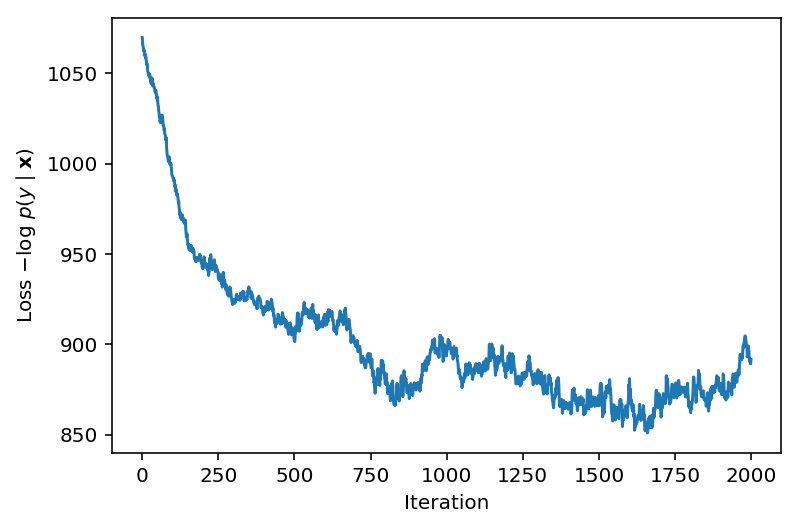

In [12]:
plt.plot(loss_history)
plt.ylabel(r'Loss $-\log$ $p(y\mid\mathbf{x})$')
plt.xlabel('Iteration')
plt.show()

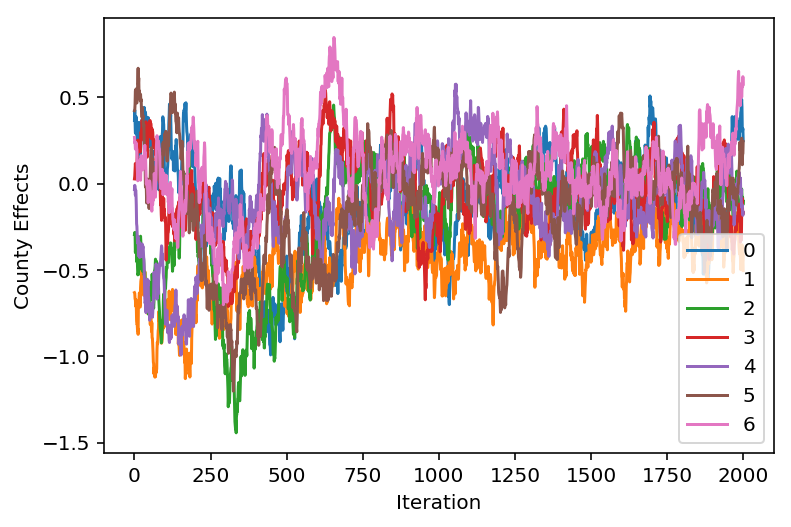

In [13]:
for i in range(7):
  plt.plot(effect_counties_samples[:, i])

plt.legend([i for i in range(7)], loc='lower right')
plt.ylabel('County Effects')
plt.xlabel('Iteration')
plt.show()

### Summarize, compare, and evaluate models

In [14]:
def interceptor(rv_constructor, *rv_args, **rv_kwargs):
  """Replaces prior on effects with empirical posterior mean from MCMC."""
  name = rv_kwargs.pop("name")
  if name == "effect_counties":
    rv_kwargs["value"] = np.mean(effect_counties_samples, 0)
  return rv_constructor(*rv_args, **rv_kwargs)

with ed.interception(interceptor):
  log_radon_posterior = model_template(features=features_test)

log_radon_prediction = log_radon_posterior.distribution.mean()

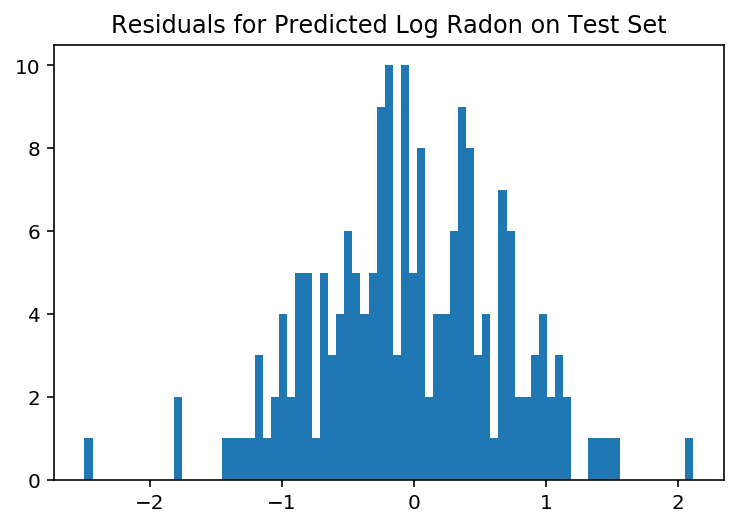

In [15]:
log_radon_pred = sess.run(log_radon_prediction)
plt.title("Residuals for Predicted Log Radon on Test Set")
# plt.xlim(-4, 4)
# plt.ylim(0, 800)
plt.hist(log_radon_pred - labels_test, 75)
plt.show()

In [16]:
[
    effect_counties_mean,
] = sess.run([
    tf.reduce_mean(effect_counties_samples, 0),
])

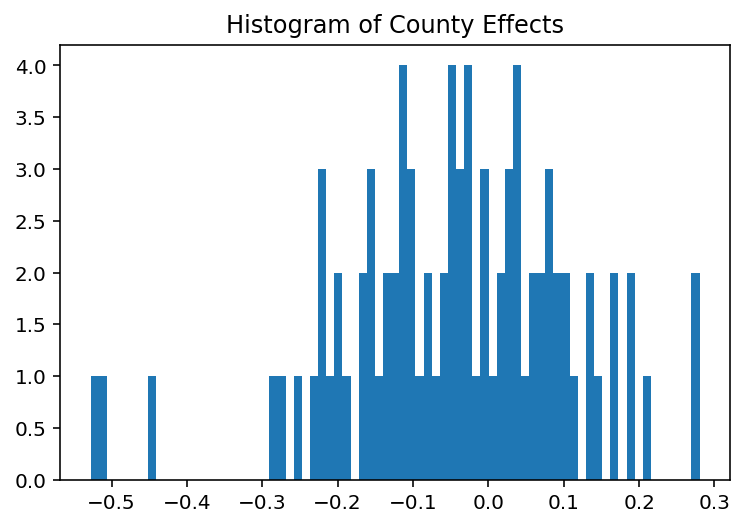

In [17]:
plt.title("Histogram of County Effects")
plt.hist(effect_counties_mean, 75)
plt.show()